코드 생성

In [280]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate

from mpl_toolkits.mplot3d import Axes3D
from collections import deque  
import random as rand

sats = [(1, 5), (2, 6), (3, 7), (4, 8), (0, 8), (1, 9), (0, 7), (1, 8), (2, 9), (1, 2),
            (2, 3), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (0, 3), (1, 4), (2, 5), (3, 6),
            (4, 7), (5, 8), (0, 2), (3, 5), (4, 6), (5, 7), (6, 8), (7, 9), (0, 5), (1, 6),
            (2, 7), (3, 8), (4, 9), (3, 9), (0, 6), (1, 7), (3, 9)]
g1tap = [2,9]
g2tap = [1,2,5,7,8,9]
# -5000, -4500, -4000, -3500, -3000, -2500, -2000, -1500, -1000, -500, 0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000
def getCode(satsNum):
    
    g1 = deque(1 for i in range(10))
    g2 = deque(1 for i in range(10))
     
    # result
    g = []
    
    # Generating 1023 chips(One C/A sequence)
    for i in range(1023):
        val = (g1[9] + g2[satsNum[0]] + g2[satsNum[1]]) % 2
        g.append(val)
        
        #shift g1
        g1[9] = sum(g1[i] for i in g1tap) % 2
        g1.rotate()
        
        #shift g2
        g2[9] = sum(g2[i] for i in g2tap) % 2
        g2.rotate()
    # 0 => -1
    for n,i in enumerate(g):
            if i==0:
                g[n]=-1
        
    return g

# 코드 미리 만들어두기(시간복잡도 줄이려고)
codes = []
for i in range(37):
    codes.append(getCode(sats[i]))

In [281]:
OV = 10
ms = 100 # message 한 bit 마다 20ms #원래는 2초 봐야해서 2000

# C/A code Frequency : 1.023MHz
# IF Frequency : 9.548MHz
# Sampling rate : 38.192MHz
# OV should be 4?
# 알아낸 곳: Kai Borre의 A Software-Defined GPS and Galileo Receiver에서의 p.55(pdf 상으로는 70페이지)
# 이것들 적용해야 하는데, 아직 할 줄 모른다...

Noise 생성

In [282]:
# 잡음의 전력 비 설정 (잡음은 전력 1, 신호전력은 1/6.31 이런 식으로 만들기)
noise_power = 6.31 # For -8dB. If -22dB, set noise_power to 158.49
#noise_power = 0.000001

# 잡음의 크기 설정
num_samples = 1023 *20 * (ms//20) * OV

# 실수부와 허수부에 대한 잡음 생성
real_noise = np.random.normal(0, 1/ (np.sqrt(2) * np.sqrt(OV)), num_samples) 
imaginary_noise = np.random.normal(0, 1/ (np.sqrt(2) * np.sqrt(OV)), num_samples) 

# 복소수로 변환
complex_noise = (real_noise + 1j * imaginary_noise) 

# 신호가 쓸 거
sigma = np.sqrt(noise_power)

Data 생성

In [283]:
data = []
for i in range(ms//20):
    data.append((-1)**i)
RN = rand.randint(0,36)
t_code = codes[RN]
t_code = [chip/(sigma*np.sqrt(OV)) for chip in t_code for _ in range(OV)]
t_code_inv = [x*-1 for x in t_code]
seq = []

# data = [1,1,-1,-1,-1]

for d in data:
    if d == 1:
        seq.extend(t_code*20)
    else:
        seq.extend(t_code_inv*20)



Signal 생성

In [284]:
class trans_signal:
    def __init__(self, code_delay, doppler_freq, svNumber, code_freq, bits, OV):
        self.delay = code_delay
        self.doppler = doppler_freq
        self.svNumber = svNumber
        self.code_freq = code_freq
        
        self.seq = np.roll(seq, code_delay) # code_delay : delay된 sample 수
        self.t = np.arange(1023 * OV * 20 * bits)
        self.oversampled_signal = np.exp(1j * 2 * np.pi * (doppler_freq + code_freq) * self.t / (1.023e6 * OV))
    def signal(self):
        return self.seq * self.oversampled_signal + complex_noise       
    def shift(self, tvar):
        self.t = self.t + tvar
        self.seq = np.roll(self.seq, -tvar)
        self.oversampled_signal = np.exp(1j * 2 * np.pi * (self.doppler + self.code_freq) * self.t / (1.023e6 * OV))
        

Replica 신호 생성

In [285]:
class Replica:
    def __init__(self, code_delay, doppler_freq, code_freq, svNumber, signal_length, OV, ts, tvar):
        ca_code = np.array(codes[svNumber])
        ca_code = [chip for chip in ca_code for _ in range(OV)]
        complement = 1023 * OV - tvar
        temp1 = np.arange((1023 * OV * ts + tvar), (1023 * OV * ts + tvar + complement)) 
        temp2 = np.arange((1023 * OV * ts + tvar + complement), (1023 * OV * ts + tvar + 1023* OV)) 
        t = np.concatenate((temp1, temp2))
        if tvar != 0:
            print(temp1[0], temp1[-1], temp2[0], temp2[-1])
        self.delayed_code = np.roll(ca_code, code_delay)
        self.oversampled_signal = np.exp(1j * 2 * np.pi * (doppler_freq + code_freq) * t / (1.023e6 * OV))
    def delay(self, delay):
        self.delayed_code = np.roll(self.delayed_code, delay)
    def signal(self):
        return self.delayed_code * self.oversampled_signal

Acquisition

In [286]:
def acquisition(signal, code_delay_range, doppler_freq_range,code_freq, svNumber, OV):
    
    # 신호 1ms씩 쪼개기
    sig = signal.signal()
    div = [sig[i:i+(1023*OV)] for i in range(0,len(sig), 1023*OV)]
    
    # 1ms 안에서 F(code 혹은 frame delay & 주파수 offset 찾기)
    max_corr = 0
    max_code_delay = 0
    max_doppler_freq = 0
    corr_matrix = np.zeros((len(code_delay_range), len(doppler_freq_range)))
    dop_freq_max = []
    Fsignal = div[0] 
    for i, doppler_freq in enumerate(doppler_freq_range):
        replica = Replica(code_delay_range[0], doppler_freq, code_freq, svNumber, 1023 * OV, OV, 0, 0)
        dop= []
        for j, code_delay in enumerate(code_delay_range):
            
            cor = np.abs(correlate(Fsignal, replica.signal(), mode='valid'))
            peak = np.max(cor)
            corr_matrix[j, i] = peak
            dop.append(peak)
            if peak > max_corr:
                max_corr = peak
                max_code_delay = code_delay
                max_doppler_freq = doppler_freq
            #replica = np.roll(replica, (OV if OV == 1 else OV//2)) # sampling 안 했을 경우 1씩, 했으면 0.5 chip씩 이동
            replica.delay(OV if OV == 1 else OV//2)
            
        dop_freq_max.append(max(dop))
    
    print('-'*40)
    print('Frame Sync completed.')
    print('Frame delay :', max_code_delay/OV)
    print('Estimated_Frequency Offset :', max_doppler_freq)
    print('Max correlation :', max_corr)
    print('-'*40)
    
    
          
    return max_code_delay, max_doppler_freq, corr_matrix, dop_freq_max
    

Acquisition 실행

In [287]:
code_delay_range = np.arange(0, 1023*OV, (OV if OV == 1 else OV//2))    # 단순히 F를 찾기 위한 범위 #늘려놓음-그래야 bit  boundary 찾는 의미 생기니까
doppler_freq_range = np.linspace(-5000, 5000, 21)  # Adjusted range of Doppler frequency in Hz
code_freq = 1.023e6  # Code frequency in Hz
svNumber = RN

# Generate received signal
true_code_delay = rand.randint(0, (20* 1023)*OV) # Range of code delay in chips (0 ~ 1023*19 + F)
true_code_delay = 10230 * 5 + 6500
true_doppler_freq = rand.randint(-5000,5000)
# true_doppler_freq = 4500

received_signal = trans_signal(true_code_delay, true_doppler_freq, svNumber, code_freq, ms//20, OV)

# Perform acquisition
estimated_code_delay, estimated_doppler_freq, corr_matrix, dop_max= acquisition(received_signal, code_delay_range, doppler_freq_range, code_freq, svNumber,OV)

print()
print("-"*18,'Test','-'*18)
print("Target SV Number:", svNumber + 1)
print("True Code Delay:", true_code_delay/OV) #frame delay?
print("True doppler frequency:", true_doppler_freq)
print('-'*40) 
B = true_code_delay//(OV*1023)
print("B :", B)
print()
# for i in range(-10,11):
#    print(f"{i*500}Hz : {dop_max[i+10]}")


----------------------------------------
Frame Sync completed.
Frame delay : 650.0
Estimated_Frequency Offset : -4000.0
Max correlation : 1263.9717145954194
----------------------------------------

------------------ Test ------------------
Target SV Number: 25
True Code Delay: 5765.0
True doppler frequency: -3988
----------------------------------------
B : 5



In [288]:
received_signal.shift(estimated_code_delay)
sig = received_signal.signal()
# complement = 1023*OV - max_code_delay
signal_div = []
"""for i in range(0, len(sig), 1023 * OV):
    if i == len(sig) - 1023*OV:
        temp1 = sig[i+max_code_delay:] 
        print('lastbit')
        temp2 = sig[0:max_code_delay]
    else:
        temp1 = sig[i+max_code_delay:i+max_code_delay + complement]
        temp2 = sig[i+max_code_delay + complement:i+max_code_delay + 1023*OV]
    res = np.concatenate((temp1, temp2))
    signal_div.append(res) """
signal_div = [sig[i:i+(1023*OV)] for i in range(0,len(sig), 1023*OV)]
cor_lst = []
for i in range(ms):
    True_replica = Replica(0, estimated_doppler_freq, code_freq, svNumber, 1023 * OV, OV, i, estimated_code_delay)
    #print(True_replica)
    #print(signal_div[i])
    cor = correlate(signal_div[i], True_replica.signal(), mode = 'valid')
    cor_lst.append(np.max(cor))

6500 10229 10230 16729
16730 20459 20460 26959
26960 30689 30690 37189
37190 40919 40920 47419
47420 51149 51150 57649
57650 61379 61380 67879
67880 71609 71610 78109
78110 81839 81840 88339
88340 92069 92070 98569
98570 102299 102300 108799
108800 112529 112530 119029
119030 122759 122760 129259
129260 132989 132990 139489
139490 143219 143220 149719
149720 153449 153450 159949
159950 163679 163680 170179
170180 173909 173910 180409
180410 184139 184140 190639
190640 194369 194370 200869
200870 204599 204600 211099
211100 214829 214830 221329
221330 225059 225060 231559
231560 235289 235290 241789
241790 245519 245520 252019
252020 255749 255750 262249
262250 265979 265980 272479
272480 276209 276210 282709
282710 286439 286440 292939
292940 296669 296670 303169
303170 306899 306900 313399
313400 317129 317130 323629
323630 327359 327360 333859
333860 337589 337590 344089
344090 347819 347820 354319
354320 358049 358050 364549
364550 368279 368280 374779
374780 378509 378510 385009
38

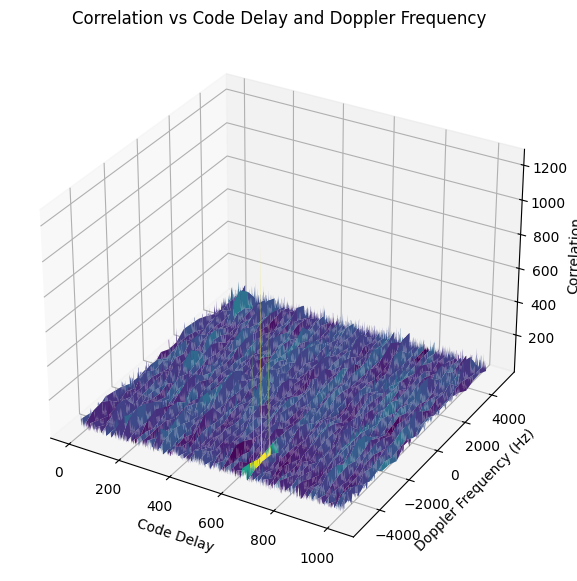

In [289]:
# Plotting
Code_Delay, Doppler_Freq = np.meshgrid(code_delay_range//OV, doppler_freq_range)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Code_Delay, Doppler_Freq, corr_matrix.T, cmap='viridis')
ax.set_xlabel('Code Delay')
ax.set_ylabel('Doppler Frequency (Hz)')
ax.set_zlabel('Correlation')
ax.set_title('Correlation vs Code Delay and Doppler Frequency')
plt.show()



In [290]:
phase_diff = []
for i in range(1, ms):
        R = cor_lst[i-1] * np.conjugate(cor_lst[i])
        phase_diff.append(np.arctan2(np.imag(R), np.real(R))) 
# R = cor_lst[0] * np.conjugate(cor_lst[-1])
# phase_diff.append(np.arctan2(np.imag(R), np.real(R)))
degree_list = [np.degrees(value) for value in phase_diff]

Index 0: -5.404540760695952
Index 1: -3.560481195750859
Index 2: -5.698843223195146
Index 3: -3.958770039063031
Index 4: -6.0815916601082085
Index 5: -1.1951661009279264
Index 6: -4.980352303597406
Index 7: -6.598511451467358
Index 8: -3.260524460515666
Index 9: -3.468865901293601
Index 10: -6.211990186441615
Index 11: -1.854684982688881
Index 12: -6.1090596248533116
Index 13: -4.022645366106802
Index 14: -3.8724383714174944
Index 15: -4.228259381688187
Index 16: -4.248879995568487
Index 17: -4.151597462163251
Index 18: -5.3161825862531
Index 19: -2.3482928010067172
Index 20: -4.840301478449065
Index 21: -4.377630694556614
Index 22: -6.403055859045939
Index 23: -1.4687159579967621
Index 24: 173.87434933301694
Index 25: -4.388708138113315
Index 26: -3.895896474893313
Index 27: -5.690676940095291
Index 28: -4.174331175094467
Index 29: -3.665460719663065
Index 30: -4.493695294451764
Index 31: -4.152911059507601
Index 32: -4.706059903142615
Index 33: -3.1005211632933367
Index 34: -4.735885

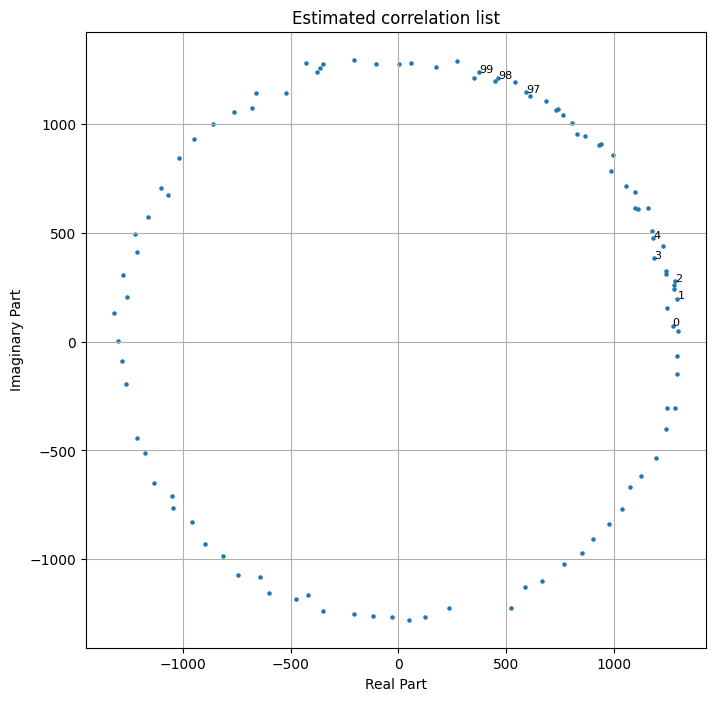

In [291]:

for idx, value in enumerate(degree_list):
    print(f"Index {idx}: {value}")



plt.figure(figsize=(8, 8))
plt.scatter(np.real(cor_lst[:]), np.imag(cor_lst[:]), s=5)

for i, txt in enumerate(range(97, 0 + ms)):
    plt.annotate(f'{txt}', (np.real(cor_lst[i+97]), np.imag(cor_lst[i+97])), fontsize = 8)
    
for i, txt in enumerate(range(0, 0 + B)):
    plt.annotate(f'{txt}', (np.real(cor_lst[i]), np.imag(cor_lst[i])), fontsize = 8)
        
plt.title("Estimated correlation list")
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
plt.grid(True)
plt.show()

# 주파수 offset = 0일 때 1~20번은 오른쪽, 21~39번이 왼쪽에 있다면 bit boundary 잘 찾은거.(부호반전)
# 위아래로 돌아간 거는 noise에 의한 영향 + 약간의 주파수 offset과 code delay에 관한 거.

In [292]:
def find_outliers(data):
    outliers = []
    threshold = 1.5 # 일반적으로는 1.5를 사용합니다.

    data_sorted = sorted(data)
    q1, q3 = np.percentile(data_sorted, [15, 85])
    iqr = q3 - q1

    lower_bound = q1 - (threshold * iqr)
    upper_bound = q3 + (threshold * iqr)

    for i, x in enumerate(data):
        if x < lower_bound or x > upper_bound:
            outliers.append(x)

    return outliers


# data = degree_list

outliers = find_outliers(degree_list)
print("이상치:", outliers)

outlier_index = 0
if len(outliers)>=1:
    tmp = outliers[0]
    print("첫번째 이상치", tmp)
    idx = degree_list.index(tmp)

    outlier_index = idx + 1
    print("원래", outlier_index)

    if outlier_index>=20:
        outlier_index = outlier_index % 20
        
    print("estimated B", outlier_index)
    print("B", B)
elif len(outliers) == 0:
    print("B = 0")
    
print()

def find_outliers_z_score(data, threshold=3):
    mean = np.mean(data)
    std = np.std(data)
    outliers = [(i + 20, x) for i, x in enumerate(data) if abs((x - mean) / std) > threshold]
    return outliers

dl = degree_list[20:40]
outliers_z = find_outliers_z_score(dl)
print("참고: 이상치 (Z-Score):", outliers_z)

이상치: [173.87434933301694, 174.55285500788415, 174.69152427240067, 177.95753138686496, -69.96898373741026]
첫번째 이상치 173.87434933301694
원래 25
estimated B 5
B 5

참고: 이상치 (Z-Score): [(24, 173.87434933301694)]


In [293]:
# degree_list = degree_list[outlier_index:] + degree_list[:outlier_index]
degree_list = np.roll(degree_list, -outlier_index)
cor_lst = np.roll(cor_lst, -outlier_index)
"""
# Added
phase_diff = []
for i in range(1, ms):
        R = cor_lst[i-1] * np.conjugate(cor_lst[i])
        phase_diff.append(np.arctan2(np.imag(R), np.real(R))) 

degree_list = [np.degrees(value) for value in phase_diff]
"""
phase_diff = np.roll(phase_diff,-outlier_index)

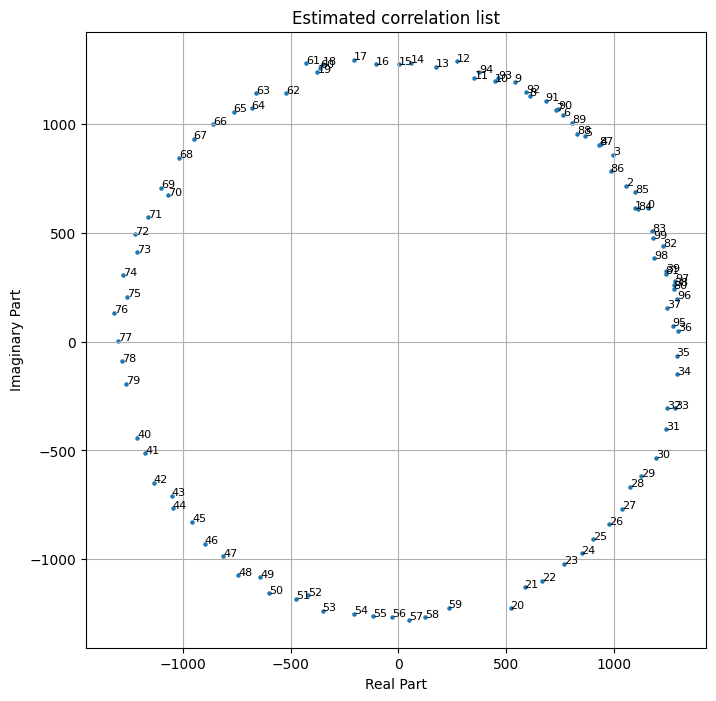

In [294]:
plt.figure(figsize=(8, 8))
plt.scatter(np.real(cor_lst[:]), np.imag(cor_lst[:]), s=5)

for i, txt in enumerate(range(0, 0 + ms)):
    plt.annotate(f'{txt}', (np.real(cor_lst[i]), np.imag(cor_lst[i])), fontsize = 8)
    
plt.title("Estimated correlation list")
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
plt.grid(True)
plt.show()

In [295]:
mean_diff_p = []
for i in range(ms//20):
    mean = np.average(phase_diff[i*20: i*20 + 18])
    print(mean)
    mean_diff_p.append(mean)

#mean_diff = [np.average(mean_diff_p)] * (ms//20)
# mean_diff_p[4] = mean_diff_p[3]

-0.07513491071784066
-0.07595699731884445
-0.07334156545774956
-0.07555418896235816
-0.14265362349255764


1 bit change
2 bit change
3 bit change
4 bit change
[1, -1, 1, -1, 1] 5


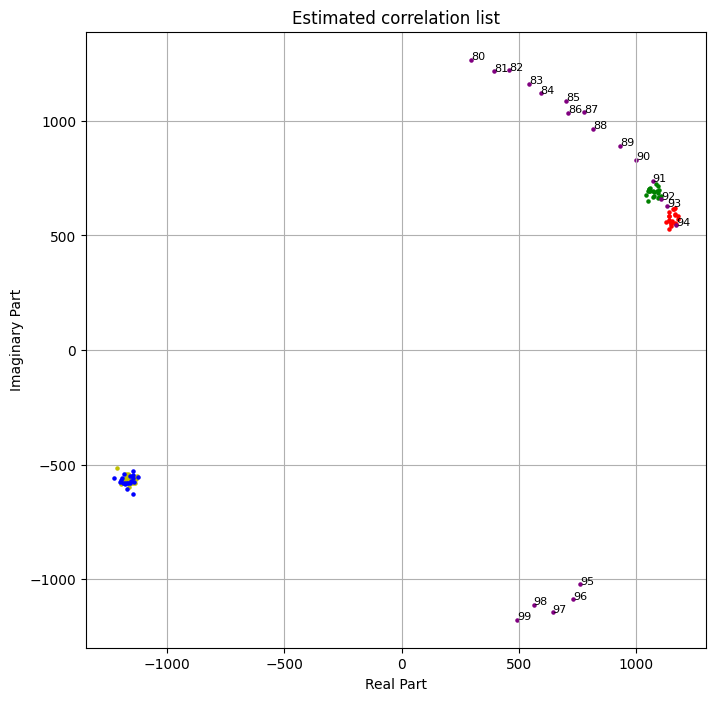

In [296]:

import cmath
# cumulative_phase = 0
new_result = []
cur_no = 0
phase_change = 0
for i in range(ms//20):
    new = [0] * 20
    if i == 0:
        # cur_no += 1
        # [0] = cor_lst[0]
        for j in range(len(cor_lst[:20])):
            current_phase = mean_diff_p[i] * cur_no 
            new[j] = cor_lst[j] * np.exp(1j * current_phase)
            cur_no += 1
    elif i != 0:
        if abs((degree_list[(20 * i) - 1])-(degree_list[20*i])) > 45:
            phase_change += 1
            print(i, "bit change")
        for j in range(20):
            current_phase = mean_diff_p[i] * cur_no  # + np.pi * phase_change
            new[j] = cor_lst[20 * i + j] * np.exp(1j * current_phase)
            cur_no += 1
    new_result += new
    
plt.figure(figsize=(8, 8))
plt.scatter(np.real(new_result[:20]), np.imag(new_result[:20]), s=5, label='New_s_1', c='r')
plt.scatter(np.real(new_result[20:40]), np.imag(new_result[20:40]), s=5, label='New_s_2', c='y')
plt.scatter(np.real(new_result[40:60]), np.imag(new_result[40:60]), s=5, label='New_s_3', c='g')
plt.scatter(np.real(new_result[60:80]), np.imag(new_result[60:80]), s=5, label='New_s_4', c='b')
plt.scatter(np.real(new_result[80:100]), np.imag(new_result[80:100]), s=5, label='New_s_5', c='purple')
# plt.scatter(np.real(new_result[100:120]), np.imag(new_result[100:120]), s=5, label='New_s_6', c='black')

print(data, B)

for i, txt in enumerate(range(80, ms)):
    plt.annotate(f'{txt}', (np.real(new_result[i+80]), np.imag(new_result[i+80])), fontsize = 8)
    
plt.title("Estimated correlation list")
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
# m = max(np.real(new_result[:]))
# plt.xlim(-1.1*m, 1.1*m)
# plt.ylim(-1.1*m, 1.1*m)
plt.grid(True)
plt.show()

In [297]:
for i, p in enumerate(degree_list):
    print(i, p)

0 -1.1951661009279264
1 -4.980352303597406
2 -6.598511451467358
3 -3.260524460515666
4 -3.468865901293601
5 -6.211990186441615
6 -1.854684982688881
7 -6.1090596248533116
8 -4.022645366106802
9 -3.8724383714174944
10 -4.228259381688187
11 -4.248879995568487
12 -4.151597462163251
13 -5.3161825862531
14 -2.3482928010067172
15 -4.840301478449065
16 -4.377630694556614
17 -6.403055859045939
18 -1.4687159579967621
19 173.87434933301694
20 -4.388708138113315
21 -3.895896474893313
22 -5.690676940095291
23 -4.174331175094467
24 -3.665460719663065
25 -4.493695294451764
26 -4.152911059507601
27 -4.706059903142615
28 -3.1005211632933367
29 -4.735885557797505
30 -5.972753624231167
31 -4.184498702203401
32 -0.43232186742653383
33 -6.710576038982161
34 -3.741640904993257
35 -5.089595158708326
36 -4.914458141712453
37 -4.286285811103779
38 -3.196289373023672
39 174.55285500788415
40 -3.5300552538798105
41 -6.157216824081063
42 -4.247323102611547
43 -2.1925540033072877
44 -4.737061970166976
45 -5.010560